__Fitting__

In this example, we'll fit the ccd imaging data we simulated in the previous exercise. We'll do this using model images generated via a tracer, and by comparing to the simulated image we'll get diagostics about the quality of the fit.

In [1]:
%matplotlib inline

from autolens.data import ccd
from autolens.data.array import mask as ma
from autolens.lens import ray_tracing, lens_fit
from autolens.model.galaxy import galaxy as g
from autolens.lens import lens_data as ld
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.data.plotters import ccd_plotters
from autolens.lens.plotters import ray_tracing_plotters
from autolens.lens.plotters import lens_fit_plotters

In [2]:
# If you are using Docker, the path you should use to output these images is (e.g. comment out this line)
# path = '/home/user/workspace/howtolens/chapter_1_introduction'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_1_introduction'

ccd_data = ccd.load_ccd_data_from_fits(image_path=path + '/data/image.fits',
                                       noise_map_path=path+'/data/noise_map.fits',
                                       psf_path=path + '/data/psf.fits', pixel_scale=0.1)

The variable ccd_data is a CCDData object, which is a 'package' of all components of the CCD data of the lens, in particular:

1) The image.
 
2) The Point Spread Function (PSF).

3) Its noise-map.

In [3]:
print('Image:')
print(ccd_data.image)
print()
print('Noise-Map:')
print(ccd_data.noise_map)
print()
print('PSF:')
print(ccd_data.psf)

Image:
[[ 0.02855024 -0.01398279  0.02019355 ...  0.00664344 -0.02165603
   0.03010757]
 [ 0.02266121  0.02684915  0.00441703 ...  0.01844175  0.05002441
   0.0416773 ]
 [ 0.02014496  0.00439093 -0.00464556 ...  0.00698484  0.02177508
  -0.02002323]
 ...
 [ 0.01715287  0.00859995  0.01010773 ...  0.00868777  0.02775036
  -0.01647311]
 [ 0.02250095  0.01718971 -0.02473338 ... -0.00894241 -0.00315085
   0.01601721]
 [ 0.0512318  -0.00749905  0.02715287 ...  0.02681163 -0.00067212
  -0.00144976]]

Noise-Map:
[[0.02070026 0.01693293 0.02001612 ... 0.01885413 0.01616003 0.02082527]
 [0.02022055 0.02056284 0.01865628 ... 0.01986972 0.0223625  0.02173149]
 [0.02001208 0.01865395 0.0178283  ... 0.01888428 0.02014738 0.01632756]
 ...
 [0.01976131 0.01902629 0.01915792 ... 0.01903398 0.02063576 0.01668601]
 [0.02020734 0.01976442 0.01583947 ... 0.01742198 0.01796748 0.0196653 ]
 [0.02245231 0.01755951 0.02058745 ... 0.0205598  0.01819596 0.01812459]]

PSF:
[[2.21033495e-12 1.98968011e-10 6.58891

To fit an image, we first specify a mask. A mask describes the sections of the image that we fit. 

Typically, we want to mask out regions of the image where the lens and source galaxies are not visible, for example at the edges where the signal is entirely background sky and noise.

For the image we simulated, a 3" circular mask will do the job. 

In [4]:
mask = ma.Mask.circular(shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, radius_arcsec=3.0)
print(mask) # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53]) # Whereas central pixels are False and therefore unmasked.

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


We can use a ccd_plotter to compare the mask and the image - this is useful if we really want to 'tailor' a mask to the lensed source's light (which in this example, we won't).

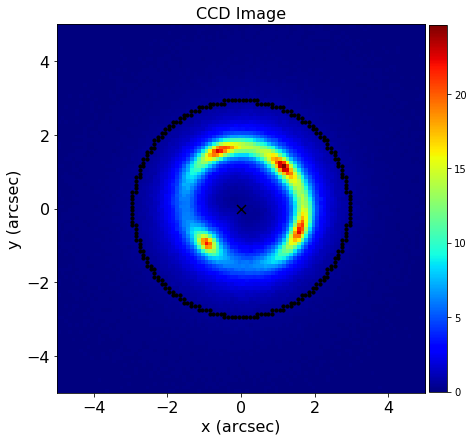

In [5]:
ccd_plotters.plot_image(ccd_data=ccd_data, mask=mask)

We can also use the mask to 'zoom' our plot around the masked region only - meaning that if our image is very large, we can focus-in on the lens and source galaxies. 

You'll see this is an option for pretty much every plotter in PyAutoLens, and is something we'll do often throughout the tutorials.

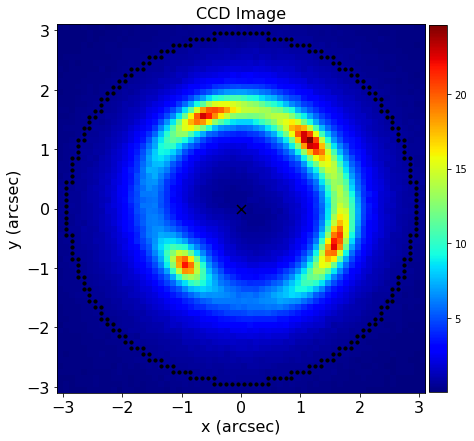

In [6]:
ccd_plotters.plot_image(ccd_data=ccd_data, mask=mask, zoom_around_mask=True)

We can also remove all pixels output of the mask in the plot, which means that if bright pixels outside the mask are messing up the color scheme and plot, they'll removed. Again, we'll do this throughout the code.

In [ ]:
ccd_plotters.plot_image(ccd_data=ccd_data, mask=mask, extract_array_from_mask=True, zoom_around_mask=True)

Now we've loaded the ccd data and created a mask, we use them to create a 'lens data' object, which we'll perform using the lens_data module (imported as 'ld').

A lens data object is a 'package' of all parts of a data-set we need in order to fit it with a lens model:

1) The ccd-data, e.g. the image, PSF (so that when we compare a tracer's image-plane image to the image data we can include blurring due to the telescope optics) and noise-map (so our goodness-of-fit measure accounts for noise in the observations).

2) The mask, so that only the regions of the image with a signal are fitted.

3) A grid-stack aligned to the ccd-imaging data's pixels: so the tracer's image-plane image is generated on the same (masked) grid as the image.

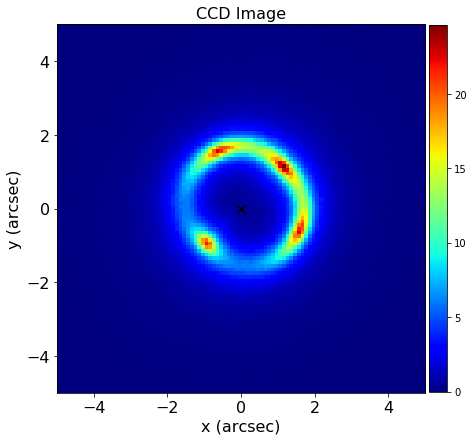

In [7]:
lens_data = ld.LensData(ccd_data=ccd_data, mask=mask)
ccd_plotters.plot_image(ccd_data=ccd_data)

By printing its attribute, we can see that it does indeed contain the image, mask, psf and so on

In [8]:
print('Image:')
print(lens_data.image)
print()
print('Noise-Map:')
print(lens_data.noise_map)
print()
print('PSF:')
print(lens_data.psf)
print()
print('Mask')
print(lens_data.mask)
print()
print('Grid')
print(lens_data.grid_stack.regular)

Image:
[[ 0.02855024 -0.01398279  0.02019355 ...  0.00664344 -0.02165603
   0.03010757]
 [ 0.02266121  0.02684915  0.00441703 ...  0.01844175  0.05002441
   0.0416773 ]
 [ 0.02014496  0.00439093 -0.00464556 ...  0.00698484  0.02177508
  -0.02002323]
 ...
 [ 0.01715287  0.00859995  0.01010773 ...  0.00868777  0.02775036
  -0.01647311]
 [ 0.02250095  0.01718971 -0.02473338 ... -0.00894241 -0.00315085
   0.01601721]
 [ 0.0512318  -0.00749905  0.02715287 ...  0.02681163 -0.00067212
  -0.00144976]]

Noise-Map:
[[0.02070026 0.01693293 0.02001612 ... 0.01885413 0.01616003 0.02082527]
 [0.02022055 0.02056284 0.01865628 ... 0.01986972 0.0223625  0.02173149]
 [0.02001208 0.01865395 0.0178283  ... 0.01888428 0.02014738 0.01632756]
 ...
 [0.01976131 0.01902629 0.01915792 ... 0.01903398 0.02063576 0.01668601]
 [0.02020734 0.01976442 0.01583947 ... 0.01742198 0.01796748 0.0196653 ]
 [0.02245231 0.01755951 0.02058745 ... 0.0205598  0.01819596 0.01812459]]

PSF:
[[2.21033495e-12 1.98968011e-10 6.58891

The image, noise-map and grids are masked using the mask and mapped to 1D arrays for fast calcuations.

In [9]:
print(lens_data.image.shape) # This is the original 2D image
print(lens_data.image_1d.shape)
print(lens_data.noise_map_1d.shape)
print(lens_data.grid_stack.regular.shape)

(100, 100)
(2828,)
(2828,)
(2828, 2)


To fit an image, we need to create an image-plane image using a tracer. Lets use the same tracer we simulated the ccd data with (thus, our fit should be 'perfect').

Its worth noting that below, we use the lens_data's grid-stack to setup the tracer. This ensures that our image-plane image will be the same resolution and alignment as our image-data, as well as being masked appropriately.

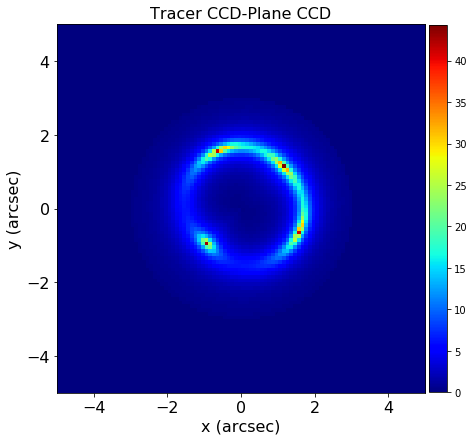

In [10]:
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grid_stack=lens_data.grid_stack)
ray_tracing_plotters.plot_image_plane_image(tracer=tracer)

To fit the image, we pass the lens data and tracer to the fitting module. This performs the following:

1) Blurs the tracer's image-plane image with the lens data's PSF, ensuring that the telescope optics are accounted for by the fit. This creates the fit's 'model_image'.

2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residual_map'.

3) Divides the residuals by the noise-map and squaring each value, creating the fit's 'chi_squared_map'. 

4) Sums up these chi-squared values and converts them to a 'likelihood', which quantities how good the tracer's fit to the data was (higher likelihood = better fit).

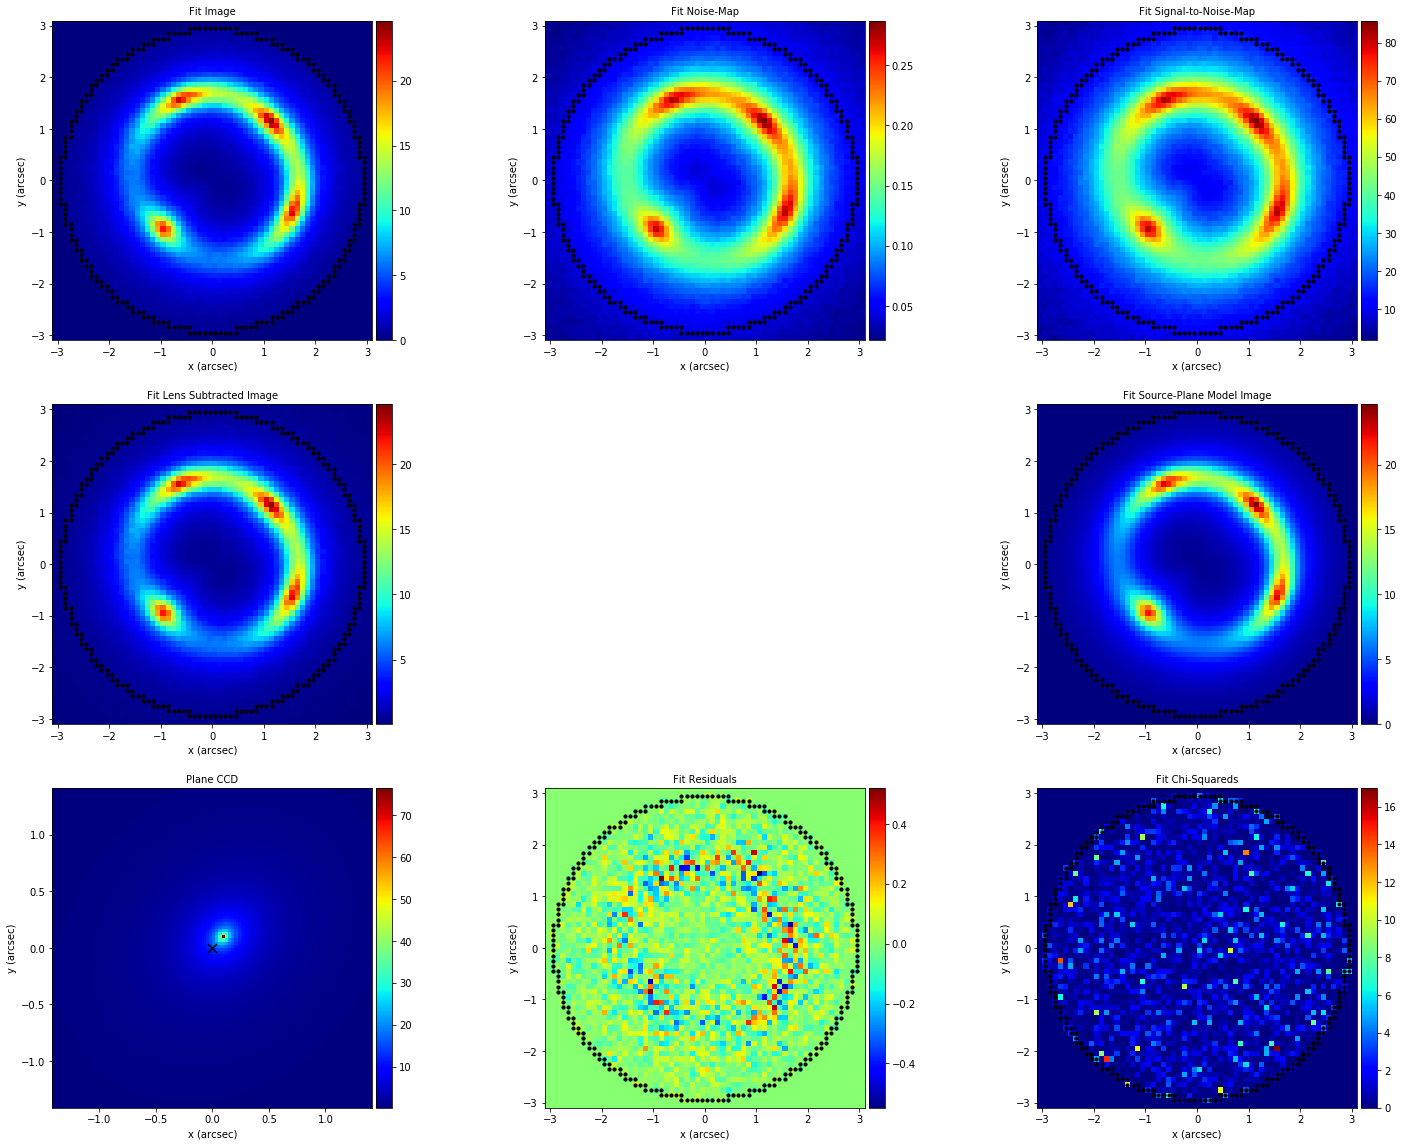

In [11]:
fit = lens_fit.fit_lens_data_with_tracer(lens_data=lens_data, tracer=tracer)
lens_fit_plotters.plot_fit_subplot(fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True)

We can print the fit's attributes - if we don't specify where we'll get all zeros, as the edges were masked:

In [12]:
print('Model-Image Edge Pixels:')
print(fit.model_image)
print()
print('Residuals Edge Pixels:')
print(fit.residual_map)
print()
print('Chi-Squareds Edge Pixels:')
print(fit.chi_squared_map)

Model-Image Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Residuals Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Chi-Squareds Edge Pixels:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Of course, the central unmasked pixels have non-zero values.

In [13]:
print('Model-Image Central Pixels:')
print(fit.model_image[48:53, 48:53])
print()
print('Residuals Central Pixels:')
print(fit.residual_map[48:53, 48:53])
print()
print('Chi-Squareds Central Pixels:')
print(fit.chi_squared_map[48:53, 48:53])

Model-Image Central Pixels:
[[0.4462173  0.44749756 0.50969855 0.59504807 0.67291882]
 [0.51307485 0.47632025 0.47610663 0.50969855 0.56369804]
 [0.67722767 0.57406417 0.47632025 0.44749756 0.48543844]
 [0.85729868 0.67722767 0.51307485 0.4462173  0.46816957]
 [0.99153157 0.75929623 0.57948483 0.50150061 0.5076683 ]]

Residuals Central Pixels:
[[-0.00711603  0.06416422 -0.00030145  0.12504807  0.03958548]
 [-0.01025848  0.01632025  0.08277329 -0.01363478 -0.0396353 ]
 [ 0.02722767 -0.01260249  0.11632025 -0.04250244  0.07877177]
 [ 0.01063201  0.05722767 -0.07025848  0.03955063 -0.0084971 ]
 [-0.02846843  0.05929623  0.03948483 -0.01849939 -0.0623317 ]]

Chi-Squareds Central Pixels:
[[2.81790737e-02 2.01927653e+00 4.47355297e-05 5.72019011e+00
  5.78585443e-01]
 [5.23723614e-02 1.34829096e-01 3.11957517e+00 9.35675030e-02
  7.55191783e-01]
 [2.76465144e-01 7.20326803e-02 5.86035650e+00 1.07315355e+00
  2.80257299e+00]
 [3.50354797e-02 1.17741709e+00 2.72813464e+00 8.01129213e-01
  3.87

It also provides a likelihood, which is a single-figure estimate of how good the model image fitted the simulated image (in unmasked pixels only!).

In [14]:
print('Likelihood:')
print(fit.likelihood)

We used the same tracer to create and fit the image. Therefore, our fit to the image was excellent. For instance, by inspecting the residuals and chi-squareds, one can see no signs of the source galaxy's light present, indicating a good fit.

This solution should translate to one of the highest-likelihood solutions possible.

Lets change the tracer, so that it's near the correct solution, but slightly off. Below, we slightly offset the lens galaxy, by 0.005"

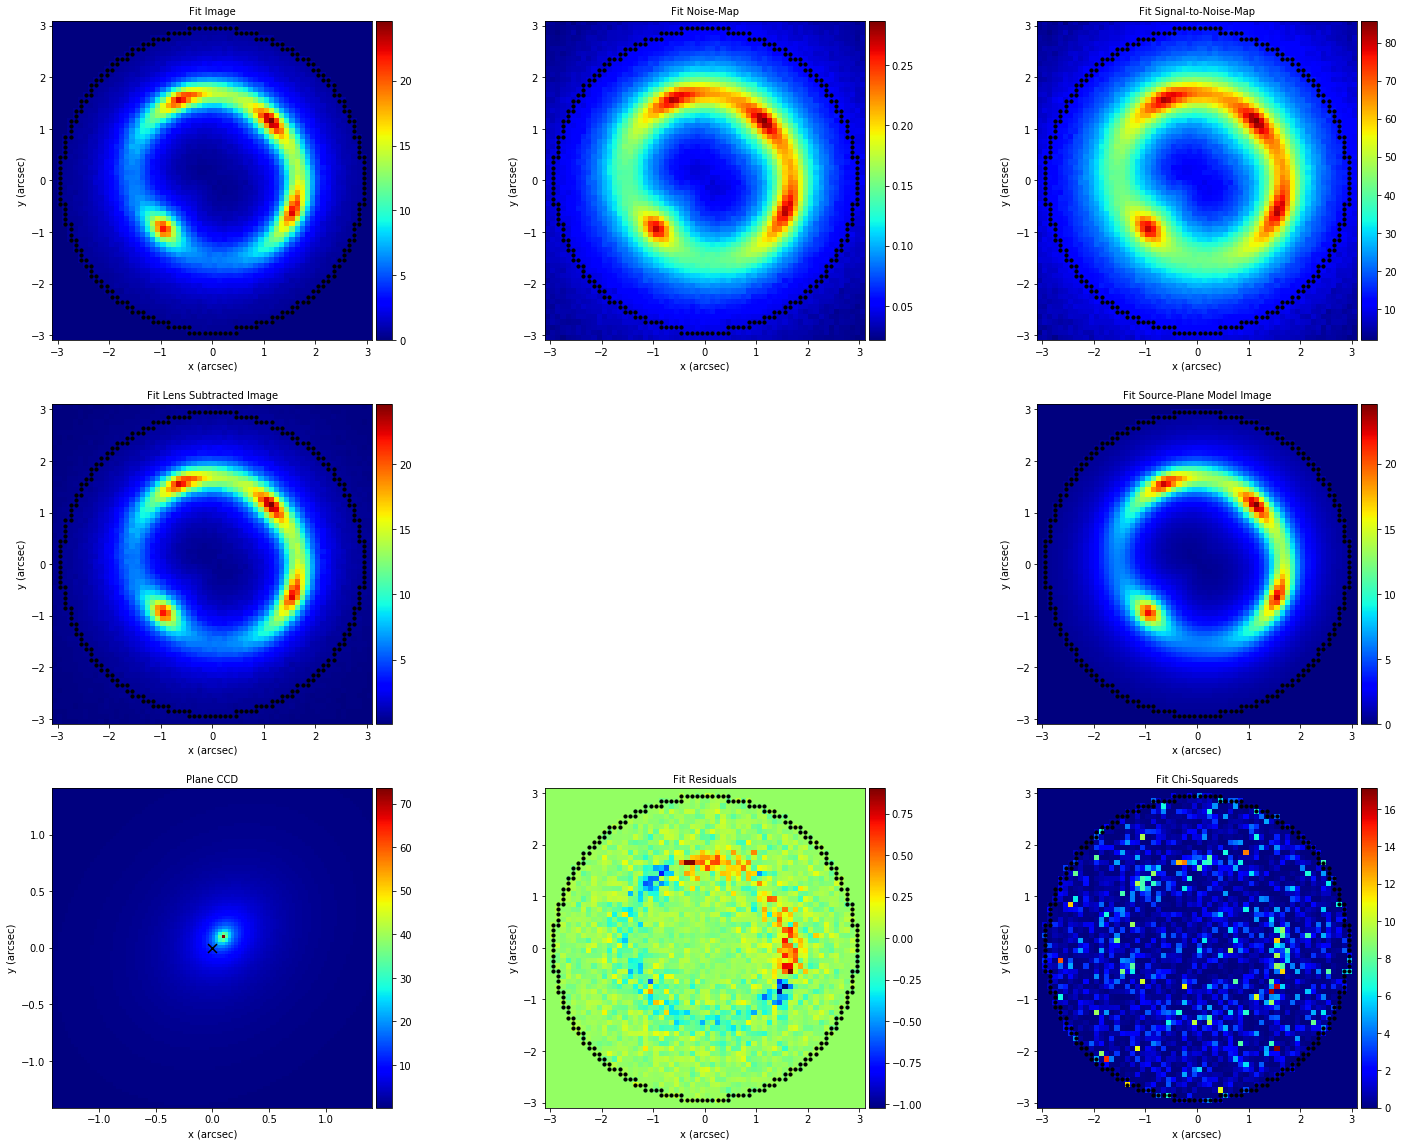

In [15]:
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grid_stack=lens_data.grid_stack)
fit = lens_fit.fit_lens_data_with_tracer(lens_data=lens_data, tracer=tracer)
lens_fit_plotters.plot_fit_subplot(fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True)

We now observe residuals to appear at the locations the source galaxy was observed, which corresponds to an increase in chi-squareds (which determines our goodness-of-fit).

Lets compare the likelihood to the value we computed above (which was 11697.24):

In [16]:
print('Previous Likelihood:')
print(11697.24)
print('New Likelihood:')
print(fit.likelihood)

Previous Likelihood:
11697.24
New Likelihood:
2647.121125015473


It decreases! This model was a worse fit to the data.

Lets change the tracer, one more time, to a solution that is nowhere near the correct one.

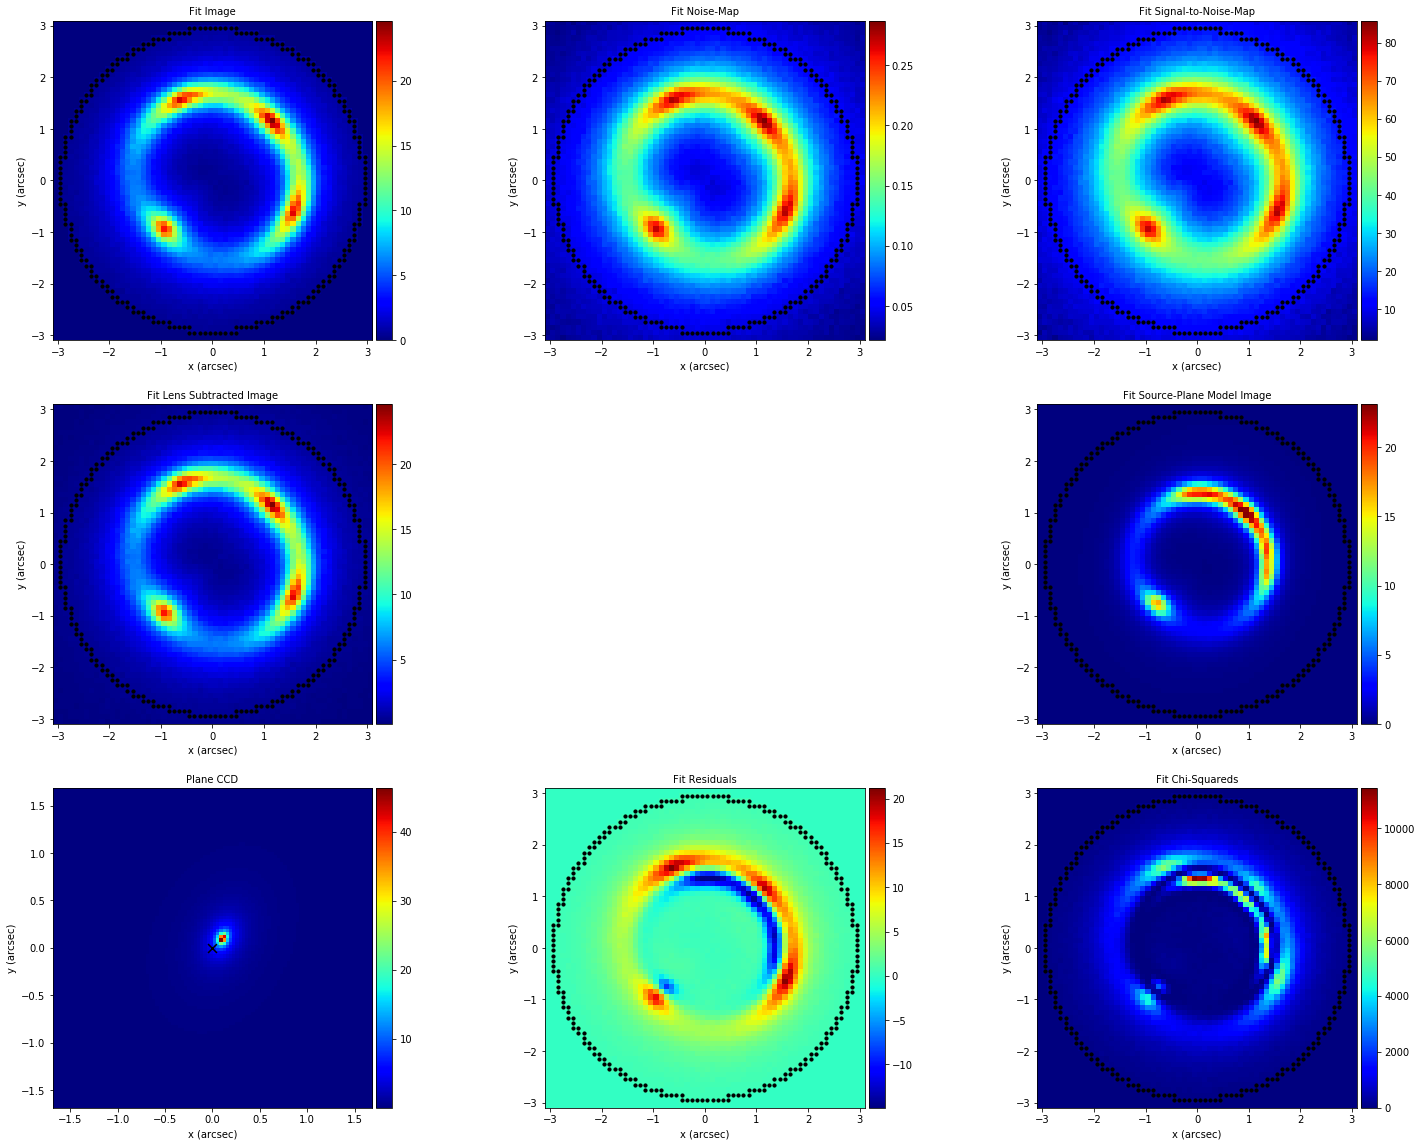

In [17]:
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.3, axis_ratio=0.8, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.7, phi=65.0,
                                                        intensity=1.0, effective_radius=0.4, sersic_index=3.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grid_stack=lens_data.grid_stack)
fit = lens_fit.fit_lens_data_with_tracer(lens_data=lens_data, tracer=tracer)
lens_fit_plotters.plot_fit_subplot(fit=fit, should_plot_mask=True, extract_array_from_mask=True, zoom_around_mask=True)

Clearly, the model provides a terrible fit, and this tracer is not a plausible representation of the image-data  (of course, we already knew that, given that we simulated it!)

The likelihood drops dramatically, as expected.

In [18]:
print('Previous Likelihoods:')
print(11697.24)
print(10319.44)
print('New Likelihood:')
print(fit.likelihood)

Previous Likelihoods:
11697.24
10319.44
New Likelihood:
-1034389.8562195668


Congratulations, you've fitted your first strong lens with PyAutoLens! Perform the following exercises:

1) In this example, we 'knew' the correct solution, because we simulated the lens ourselves. In the real Universe, we have no idea what the correct solution is. How would you go about finding the correct solution?  Could you find a solution that fits the data reasonable through trial and error?
